In [ ]:
import jax
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad
from jax.experimental import optimizers,stax
from jax.example_libraries.stax import (AvgPool, BatchNorm, Conv, Dense,
                                        FanInSum, FanOut, Flatten, GeneralConv,
                                        Identity, MaxPool, Relu, LogSoftmax)
from jax.experimental.optimizers import optimizer, make_schedule, exponential_decay
from jax import image
#from jax.ops import index, index_update

import itertools
from functools import partial
from tqdm import trange
from torch.utils import data
import matplotlib.pyplot as plt

from scipy.integrate import odeint

from jax.nn import sigmoid,relu,log_sigmoid,one_hot
from jax.lax import scan
import h5py
from sklearn.metrics import confusion_matrix

In [ ]:
from jax.nn.initializers import glorot_normal, normal, ones, zeros

In [ ]:
from jax.nn import softmax

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm/ np.sum(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# DATA

In [ ]:
from keras.datasets import cifar10
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [ ]:
x_train=np.asarray(x_train)
x_test=np.asarray(x_test)

In [ ]:
x_train=x_train/255.
num_classes=y_train.max()+1
y_train=y_train.flatten()
y_train=one_hot(y_train,num_classes)

print(x_train.shape)
print(y_train.shape)

train_dataset = DataGenerator(x_train, y_train, batch_size=128)

(50000, 32, 32, 3)
(50000, 10)


# ResNet

In [ ]:
! pip install jax-resnet

In [ ]:
from jax_resnet.resnet import ResNet50

In [ ]:
class ResNet:
    # Initialize the class
    rng_key = random.PRNGKey(0)
    def __init__(self, rng_key=random.PRNGKey(0)):
        # MLP init and apply functions
        self.resnet=ResNet50(n_classes=10)
#        self.net_init, self.net_apply = ResNet50(n_classes=10)
        params = self.resnet.init(rng_key, np.ones((128,32,32,3)))

        # Optimizer initialization and update functions
        #lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        lr=1e-3
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        images, labels = batch
        outputs = self.resnet.apply(params, images, mutable=False)
        outputs = softmax(outputs)
        loss = -labels*np.log(outputs+1e-7)
        return np.mean(loss)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        outputs = self.resnet.apply(params, inputs,mutable=False)
        outputs = softmax(outputs)
        return outputs

In [ ]:
# Initialize model
model = ResNet()

100%|██████████| 10000/10000 [06:35<00:00, 25.28it/s, Loss=0.0010551726]


Text(0, 0.5, 'Loss')

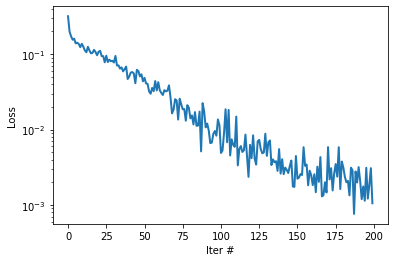

In [ ]:
# Train model
model.train(train_dataset, nIter=10000)
opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

In [ ]:
x_test=x_test/255.
num_classes=y_test.max()+1
y_test=y_test.flatten()
y_test=one_hot(y_test,num_classes)
x_test=np.asarray(x_test)
test_dataset = DataGenerator(x_test, y_test, batch_size=128)

In [ ]:
# Compute classification accuracy on the entire test data-set
@jit
def accuracy(params, batch):
    images, labels = batch
    outputs = model.predict(params, images)
    pred_class = np.argmax(outputs,1)
    true_class = np.argmax(labels,1)
    return np.sum((pred_class == true_class)) / images.shape[0]

acc = accuracy(opt_params, (x_test, y_test))
print('Classification accuracy: {}%'.format(100*acc))

Classification accuracy: 68.43000030517578%


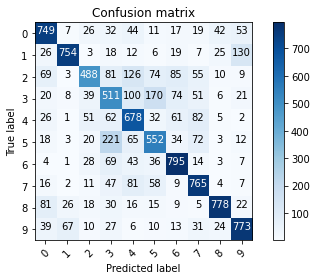

In [ ]:
# Plot the confusion matrix
outputs = model.predict(opt_params, x_test)
pred_class = np.argmax(outputs,1)
true_class = np.argmax(y_test,1)
M = confusion_matrix(true_class, pred_class)
plt.figure()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=False)